### Cab-Driver Agent

In [42]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

#### Defining Time Matrix

In [43]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [44]:
# Initialise states_tracked as 'states_track' (for convergence)
states_track = collections.defaultdict(dict)

In [45]:
def initialise_tracking_states():
    sample_q_values = [((3,0,2),(3,1)),((1,6,3),(2,3)),((2,2,2),(3,2)),((3,10,6),(3,4)),((0,20,3),(1,4)), ((1,23,3),(1,4))]    #select any 4 Q-values
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        states_track[state][action] = []

In [46]:
initialise_tracking_states()

In [47]:
def save_tracking_states():
    for state in states_track.keys():
        for action in states_track[state].keys():
            state_encod = env.state_trans(state)
            state_encod = np.reshape(state_encod, [1, agent.state_size])
            prediction = agent.model.predict(state_encod)
            action_list = list(action)
            action_index = env.action_space.index(action_list)
            Q = prediction[0][action_index]
            states_track[state][action].append(Q) 

In [38]:
#Defining a function to save the states_tracked as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [39]:
# Defining Parameters
m = 5 # number of cities, ranges from 1 ..... m
t = 24 # number of hours, ranges from 0 .... t-1
d = 7  # number of days, ranges from 0 ... d-1m = 5

In [40]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = m+t+d 
        self.action_size = m*(m-1) + 1
        self.action_space = [[i,j] for i in range(m) for j in range(m) if i!=j or i==0]

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.001   
        self.epsilon_max = 1.0
        self.epsilon_decay = 0.0003
        self.epsilon_min = 0.00000001
        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=5000)

        # create main model and target model
        self.model = self.build_model()

    # building model 
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(200, input_dim = self.state_size,activation ='relu'))
        model.add(Dense(150,activation ='relu'))
        model.add(Dense(100,activation ='relu'))
        model.add(Dense(self.action_size,activation ='linear'))

        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model

    def get_action(self, state, episode):
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment       
        poss_actions_index, poss_actions = env.requests(state)
        epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp(-self.epsilon_decay*episode)
        if np.random.rand() <= epsilon: # Exploration: randomly choosing and action
            action = random.choice(poss_actions)
        else: #Exploitation: this gets the action corresponding to max q-value of current state
            state_encod = env.state_trans(state)
            state_encod = np.reshape(state_encod, [1, self.state_size])
            q_value = self.model.predict(state_encod)
            q_value = q_value[0][poss_actions_index]
            action_index = np.argmax(q_value)
            action = poss_actions[action_index]
        return action, epsilon


    def append_sample(self, state, action, reward, next_state, terminal_state):
        # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state, terminal_state))
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size)) # write here
            update_input = np.zeros((self.batch_size, self.state_size)) # write here
            
            actions, rewards, terminal_states = [], [], []
            
            for i in range(self.batch_size):
                #Predict the target from earlier model
                state, action, reward, next_state,terminal_state  = mini_batch[i]
                            
                actions.append(self.action_space.index(action))
                rewards.append(reward)
                terminal_states.append(terminal_state)
                
                update_input[i] = env.state_trans(state)
                update_output[i] = env.state_trans(next_state)
                #Get the target for the Q-network 
                target = self.model.predict(update_input)
                target_val = self.model.predict(update_output)
                             
            for i in range(self.batch_size):
                if terminal_states[i]:
                    target[i][actions[i]] = rewards[i]
                else:
                    target[i][actions[i]] = rewards[i] + self.discount_factor * (np.amax(target_val[i]))

                
            #Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            
            # save model
            save_obj(self.model, "DQN_model")

    def save(self, name):
        self.model.save(name)

In [41]:
# Initialising the required variables 
avg_reward = []

# tracking total rewards per episode
total_reward  = []

Episodes = 200

threshold = 20      #every 20 episodes, the 4 Q-values will be stored/appended (convergence graphs)


### DQN block

In [31]:
start_time = time.time()
for episode in range(Episodes):

    # Call the environment
    env = CabDriver()

    state_size = len(env.state_space)
    action_size = len(env.action_space)

    # agent needs to be initialised outside the loop since the DQN
    # network will be initialised along with the agent
    agent = DQNAgent(state_size, action_size)

    # Call all the initialised variables of the environment
    # tracking total rewards, step count
    tot_reward = 0
    step_count = 0
    state = env.reset()
    terminal_state = False


    #Call the DQN agent
    
    
    while terminal_state!=True:
        
        # Pick epsilon-greedy action from possible actions for the current state
        action, epsilon = agent.get_action(state, episode)
        
        # Evaluate your reward and next state        
        reward = env.reward_func(state, action, Time_matrix)        
        next_state, terminal_state = env.next_state_func(state, action, Time_matrix)
        
        # save the sample <s, a, r, s'> to the replay memory
        agent.append_sample(state, action, reward, next_state, terminal_state)
        
        # every time step do the training
        agent.train_model()
        #Keep a track of rewards, Q-values, loss
        tot_reward += reward
        state = next_state
        step_count += 1
        
        # Store the rewards
        if terminal_state and episode % 25 ==0:
            avg_reward.append(tot_reward/step_count)
            total_reward.append(tot_reward)
            print("episode:", episode, "  score:", tot_reward, "  memory length:",
                      len(agent.memory), "  epsilon:", epsilon)
    
        if episode % 200 == 0:
            agent.save("./cab_driver.h5")

        #Saving States-action Q-values for Convergence
        if ((episode+1) % threshold) == 0:   #every 2000th episode
            save_tracking_states()
            save_obj(states_track,'States_tracked')   
    
elapsed_time = time.time() - start_time

save_obj(states_track,'States_tracked')   
print(episode)

episode: 0   score: -155.0   memory length: 134   epsilon: 1.0
episode: 25   score: -186.0   memory length: 143   epsilon: 0.9925280548938579


KeyboardInterrupt: 

### Tracking Convergence

In [ ]:
states_track

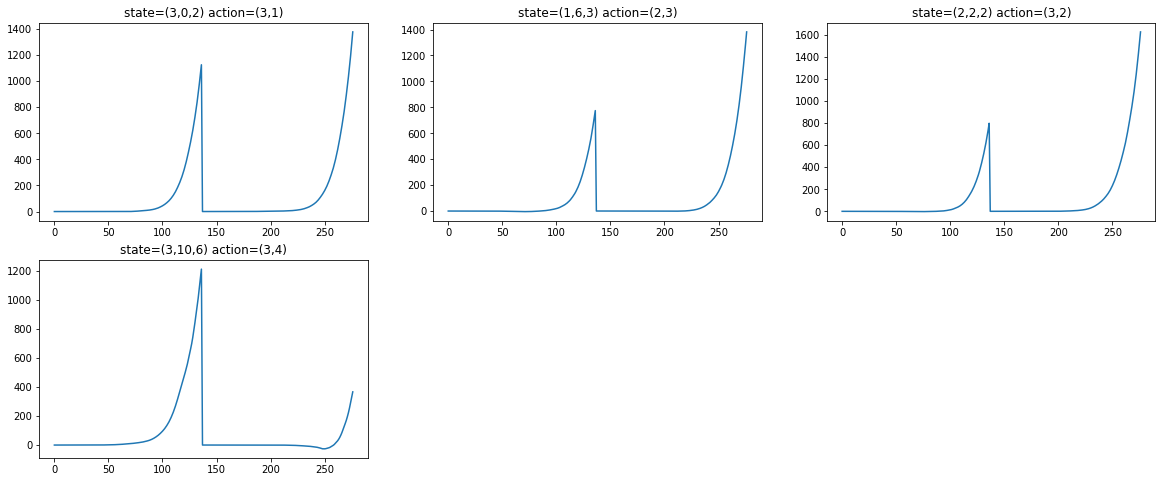

In [16]:
#Plotting the graphs for few states and actions to check for Q-value convergence
fig = plt.figure(figsize=(20, 8))

#State - Action Pair 1 Plot
state_action_pair_1 =states_track[(3,0,2)][(3,1)]
plt.subplot(231)
xaxis=np.asarray(range(0,len(state_action_pair_1)))
plt.title('state=(3,0,2) action=(3,1)')
plt.plot(xaxis, np.asarray(state_action_pair_1))

#State - Action Pair 2 Plot
state_action_pair_2 =states_track[(1,6,3)][(2,3)]
xaxis=np.asarray(range(0,len(state_action_pair_2)))
plt.subplot(232)
plt.title('state=(1,6,3) action=(2,3)')
plt.plot(xaxis, np.asarray(state_action_pair_2))

#State - Action Pair 3 Plot
state_action_pair_3 =states_track[(2,2,2)][(3,2)]
plt.subplot(233)
plt.title('state=(2,2,2) action=(3,2)')
xaxis=np.asarray(range(0,len(state_action_pair_3)))
plt.plot(xaxis, np.asarray(state_action_pair_3))

#State - Action Pair 4 Plot
state_action_pair_4 =states_track[(3,10,6)][(3,4)]
plt.subplot(234)
plt.title('state=(3,10,6) action=(3,4)')
xaxis=np.asarray(range(0,len(state_action_pair_4)))
plt.plot(xaxis, np.asarray(state_action_pair_4))


#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [17]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

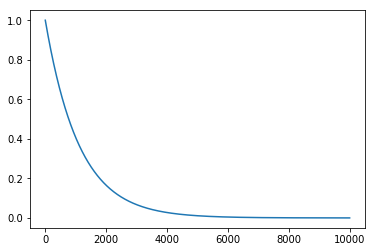

In [18]:
plt.plot(time, epsilon)
plt.show()